In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(12, 6)})

# for custom notebook formatting.
from IPython.core.display import HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
HTML(open('../custom.css').read())



<br>

## Natural Language Processing
### :::: Recurrent Neural Networks ::::

<br>

<br><br><br><br><br><br>


## Previously

Hidden Markov models can make predictions over a sequence.

Some limitations:

- long-range dependencies: "The **students** studied for **their** test."
  - must "remember" that "students" is plural to know to use "their" and not "his/hers"
- forward only: only considers previous words, but future words may help for, e.g., part-of-speech tagging


<br><br>

Why is it hard to include long-range dependencies?


$$p(q_i \mid q_{i-1}) = \frac{C(q_{i-1}, q_i)}{C(q_{i-1})}$$

$$p(q_i \mid q_{i-1}, q_{i-2}) = \frac{C(q_{i-2}, q_{i-1}, q_i)}{C(q_{i-1}, q_{i-2})}$$

$$p(q_i \mid q_{i-1}, q_{i-2}, q_{i-3}) = \frac{C(q_{i-3}, q_{i-2}, q_{i-1}, q_i)}{C(q_{i-1}, q_{i-2}, q_{i-3})}$$

![trellis](figs/trellis.png)

## Recurrent Neural Networks

(adapted from [here](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/))

- Sequence model for neural networks
- Similar to Hidden Markov models

![rnn_roll](figs/rnn_roll.png)

- $x_t$: input at time  $t$.
  - E.g., a word.
- $h_t$: hidden state at time  $t$.
  - The “memory” of the network. 
  - $h_t$ is a function of the previous hidden state ($h_{t-1}$) and the current input ($x_t$).
    - Similar to HMMs, where we have $p(y_t \mid y_{t-1}, x_t)$
    - $h_t=f(W_{xh}x_t + W_{hh} h_{t-1})$
      - $f$ :  activation function (e.g., sigmoid, tanh, etc)
      - $W_{xh}$: analogous to "emission" probabilities in HMMs
      - $W_{hh}$: analogous to "transition" probabilities in HMMs
- $y_t$: output at time $t$
  - E.g., to predict the next word in a sentence it would be a vector of probabilities across our vocabulary. $y_t = \mathrm{softmax}(W_{hy}h_t).$

<br>

This "unrolled" network is a multi-layer neural net

- E.g., if the sentence has 5 words, we have 5 layers
- Unlike a typical neural net, the parameters are <u>shared</u> across layers
  - That is, $W_{xh}$, $W_{hh}$, and $W_{hy}$ are the same everywhere.
  

<br><br>

Dimensions of weight matrices depends on

- input dimension $d_x~~~~~~~~~~~~~~~~$ $x_t \in \mathbb{R}^{d_x}$
- hidden state dimension $d_h~~~~$ $h_t \in \mathbb{R}^{d_h}$
- output dimension $d_y~~~~~~~~~~~~~~$ $y_t \in \mathbb{R}^{d_y}$

thus

- $W_{xh} \in \mathbb{R}^{d_h \times d_x}$
- $W_{hh} \in \mathbb{R}^{d_h \times d_h}$
- $W_{hy} \in \mathbb{R}^{d_y \times d_h}$

<br><br>

Unlike HMMs, we will estimate parameters $W_{xh}$, $W_{hh}$, and $W_{hy}$ with gradient descent (rather than counting)

<br><br>

<br><br><br>

## Types of Recurrent NNs
(following [this nice tutorial](http://karpathy.github.io/2015/05/21/rnn-effectiveness/))

  
![rnn_styles](figs/rnn_styles.png)
- red=input
- green=network state
- blue=output
<br><br>
- one-to-one: no RNN; e.g., image classification
- one-to-many: image -> caption
- many-to-one: sentiment classification
- many-to-many, unsynchronized: translation
- many-to-many, synchronized: POS tagging
  


<br><br>

## A simple implementation of Recurrent Neural Nets

A basic RNN has a `step` function, which takes an `x` vector as input and returns a `y` vector as output.

Letting
- $W_{hh}$ be the transition weights (from hidden state $t$ to hidden state $t+1$)
- $W_{xh}$ be the emission weights (from hidden state $h$ to observation $x$)
- $W_{hy}$ be the output weights (from hidden state $h$ to prediction $y$)
- $\mathrm{tanh}(z) \in [-1, 1]$ be the activation function
  - like logistic, but in $[-1,1]$ instead of $[0,1]$

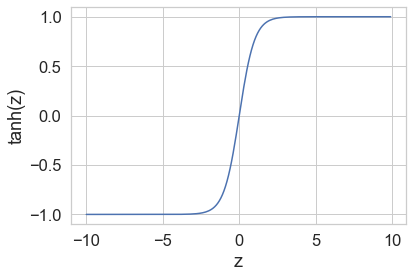

In [6]:
# tanh activation function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

zs = np.arange(-100,100) / 10
plt.figure()
plt.plot(zs, [np.tanh(z) for z in zs])
plt.ylabel('tanh(z)')
plt.xlabel('z')
plt.show()

To update the hidden state $h$:

$$h_t = \mathrm{tanh}(W_{hh}h_{t-1} + W_{xh}x_t)$$

To compute the output vector $y$:

$$y_t = W_{hy} h_t$$

```python
class RNN:
  def step(self, x):
    # update the hidden state
    self.h = np.tanh(np.dot(self.W_hh, self.h) + np.dot(self.W_xh, x))
    # compute the output vector
    y = np.dot(self.W_hy, self.h)
    return y

```

In [7]:
### RNN
class RNN:
    def __init__(self, n_input, n_hidden, n_output):
        # initialize to small weights
        np.random.seed(42)
        self.W_xh = np.random.randn(n_hidden, n_input) * .01
        self.W_hh = np.random.randn(n_hidden, n_hidden) * .01
        self.W_hy = np.random.randn(n_output, n_hidden) * .01
        self.h = np.random.randn(n_hidden, 1) * .01

    def step(self, x):
        # update the hidden state
        self.h = np.tanh(np.dot(self.W_hh, self.h) + np.dot(self.W_xh, x))
        # compute the output vector
        print(self.h.shape)
        y = np.dot(self.W_hy, self.h)
        return y

    def __str__(self):
        return 'W_xh:\n%s\nW_hh:\n%s\nW_hy:%s\nh:\n%s\n' % (
            str(self.W_xh),
            str(self.W_hh),
            str(self.W_hy),
            str(self.h)
                                                           )

## RNN Example: Character Language Model

Predict the next character in the sequence.

![char](figs/char.png)

In [24]:
n_chars = 28  # +1 for space and period.
n_hidden = 3
rnn = RNN(n_chars, n_hidden, n_chars)
print(rnn)
# random weights

RNN(
  (input_to_hidden): Linear(in_features=28, out_features=3, bias=True)
  (hidden_to_hidden): Linear(in_features=3, out_features=3, bias=True)
  (hidden_to_output): Linear(in_features=3, out_features=28, bias=True)
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
)


### One-hot encoding
We represent each character as a binary vector, with a `1` in the cell corresponding to that letter.

![letter](figs/letter.png)

In [25]:
import string

chars = list(string.ascii_lowercase) + [' ', '.']
char2int = dict()
int2char = dict()
for i, c in enumerate(chars):
    char2int[c] = i
    int2char[i] = c
    
sorted(char2int.items(), key=lambda x: x[1])

[('a', 0),
 ('b', 1),
 ('c', 2),
 ('d', 3),
 ('e', 4),
 ('f', 5),
 ('g', 6),
 ('h', 7),
 ('i', 8),
 ('j', 9),
 ('k', 10),
 ('l', 11),
 ('m', 12),
 ('n', 13),
 ('o', 14),
 ('p', 15),
 ('q', 16),
 ('r', 17),
 ('s', 18),
 ('t', 19),
 ('u', 20),
 ('v', 21),
 ('w', 22),
 ('x', 23),
 ('y', 24),
 ('z', 25),
 (' ', 26),
 ('.', 27)]

In [26]:
# to create letter "h"
import torch
def char2vec(char, char2int):
    x = torch.zeros((1, len(char2int)))
    x[0][char2int[char]] = 1
    return x
def chars2vec(chars, char2int):
    return torch.cat([char2vec(c, char2int) for c in chars])
print(char2vec('h', char2int))
print()
print(chars2vec('hello', char2int))

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])



$$h_t = \mathrm{tanh}(W_{hh}h_{t-1} + W_{xh}x_t)$$

$$y_t = W_{hy} h_t$$


Output vector are weights for the next letter.

Higher weights == more likely letter.

To convert to probabilities, use softmax:

$$
p_t(i) = \frac{e^{y_t(i)}}{\sum_j e^{y_t(j)}}
$$

## Comparison with HMMs

Recall the HMM transition probabilities:
$$p(q_t \mid q_{t-1}) = \frac{C(q_{t-1}, q_t)}{C(q_{t-1})}$$

In RNNs, we instead have a $h$ x $h$ matrix $W_{hh}$ representing transitions:

![trans](figs/trans.png)

So, whereas in HMMs the states are discrete variables, in RNNs the states are vectors of real numbers, representing the assignment to hidden units.
<br>
This provides additional modeling flexibility:
- E.g., in named-entity tagging, not all adjectives have the same meaning
  - "tall" modifies a Person, "expansive" modifies a Location
- Different adjectives can have different hidden units

<br><br>

## Error function

For the character language model, the training set consists of raw text.

We know the true character that should exist at position $t$.

We can compute the log probability of that true character according to the model, and minimize the negative log of that value.

$$
p_t(i) = \frac{e^{y_t(i)}}{\sum_j e^{y_t(j)}}
$$

$$
E(y_t(i)) = -\log p_t(i)
$$

where $i$ is the true label at time $t$.

We take the average error over all characters as the total error for the current model:

$$
E = \frac{1}{N} \sum_t -\log p_t(i)
$$


##### Gradient
(See [here](http://cs231n.github.io/neural-networks-case-study/#grad) for derivation)

$$
\frac{\partial E(y_t(i))}{\partial y_t(k)} = p_t(k) - \mathbf{1}(y_i = k)
$$
where $\mathbf{1}(y_i = k)$ is $1$ if $y_i=k$.

E.g., if probabilities are [0.2, 0.3, 0.5], and that the correct class was 2 (the middle one).  
The gradient on the scores would be df = [0.2, -0.7, 0.5]. 

<br><br>

Let's implement this in pytorch.

In [27]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, verbose=True):
        super(RNN, self).__init__()
        self.verbose = verbose
        self.n_hidden = hidden_size
        # W_xh
        self.input_to_hidden = nn.Linear(input_size, hidden_size)
        # W_hh
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size)
        # W_hy
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, h_prev):
        # tanh(𝑊_hh h_t-1 + W_xh x_t)
        h_new = self.tanh(self.hidden_to_hidden(h_prev) + self.input_to_hidden(x))
        # y_h = softmax(W_hy h)
        output = self.softmax(self.hidden_to_output(h_new))
        
        if self.verbose: print('h_new\n', h_new, '\noutput\n',output, '\ntop output\n', output2label(output, chars))
        return output, h_new
    
    def forward_unrolled(self, x_list):
        """
        Given a character list, unroll the network and gather
        predictions for each time step.
        """
        hidden = torch.zeros(1, self.n_hidden)
        outputs = []
        hiddens = []
        for x in x_list[:-1]: # no prediction for final step
            output, hidden = self.forward(x, hidden)
            outputs.append(output)
            hiddens.append(hidden)
        return torch.cat(outputs), hidden
    
def output2label(output, chars):
    """
    return the letter for the most probable prediction
    """
    top_n, top_i = output.topk(1)
    return chars[top_i.item()] # , math.exp(top_n)

torch.random.manual_seed(42)
rnn = RNN(n_chars, n_hidden, n_chars)
x = char2vec('h', char2int)
hidden = torch.zeros(1, n_hidden)
output, hidden = rnn.forward(x, hidden)

h_new
 tensor([[ 0.6377, -0.1223, -0.1603]], grad_fn=<TanhBackward>) 
output
 tensor([[0.0210, 0.0489, 0.0425, 0.0310, 0.0373, 0.0246, 0.0303, 0.0337, 0.0263,
         0.0451, 0.0504, 0.0244, 0.0321, 0.0397, 0.0262, 0.0366, 0.0577, 0.0244,
         0.0222, 0.0677, 0.0341, 0.0377, 0.0230, 0.0300, 0.0208, 0.0266, 0.0517,
         0.0539]], grad_fn=<SoftmaxBackward>) 
top output
 t


In [28]:
outputs, hiddens = rnn.forward_unrolled(chars2vec('abc', char2int))

h_new
 tensor([[ 0.6572, -0.2183, -0.0368]], grad_fn=<TanhBackward>) 
output
 tensor([[0.0219, 0.0512, 0.0428, 0.0344, 0.0347, 0.0253, 0.0296, 0.0345, 0.0262,
         0.0501, 0.0494, 0.0230, 0.0313, 0.0417, 0.0238, 0.0377, 0.0527, 0.0251,
         0.0200, 0.0689, 0.0329, 0.0411, 0.0252, 0.0301, 0.0200, 0.0258, 0.0468,
         0.0536]], grad_fn=<SoftmaxBackward>) 
top output
 t
h_new
 tensor([[ 0.5098, -0.3155,  0.2550]], grad_fn=<TanhBackward>) 
output
 tensor([[0.0254, 0.0537, 0.0430, 0.0450, 0.0284, 0.0277, 0.0293, 0.0345, 0.0259,
         0.0616, 0.0500, 0.0225, 0.0284, 0.0436, 0.0214, 0.0409, 0.0405, 0.0245,
         0.0178, 0.0675, 0.0337, 0.0454, 0.0300, 0.0278, 0.0184, 0.0241, 0.0368,
         0.0522]], grad_fn=<SoftmaxBackward>) 
top output
 t


In [29]:
chars = ['a', 'b', 'c']
char2int = {'a': 0, 'b': 1, 'c': 2}
int2char = {0: 'a', 1: 'b', 2: 'c'}
data = [
    chars2vec('abcabcabc', char2int),
    chars2vec('bcabcabca', char2int),
    chars2vec('cabcabcab', char2int)
]  * 100

len(data)

300

In [30]:
data[0]

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

100%|██████████| 30/30 [00:10<00:00,  3.00it/s]


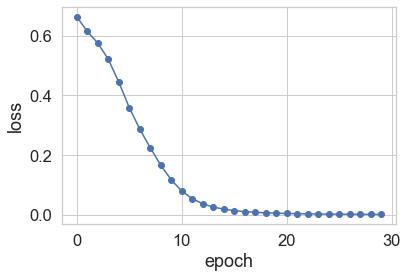

RNN(
  (input_to_hidden): Linear(in_features=3, out_features=3, bias=True)
  (hidden_to_hidden): Linear(in_features=3, out_features=3, bias=True)
  (hidden_to_output): Linear(in_features=3, out_features=3, bias=True)
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
)

In [31]:
from tqdm import tqdm
def train_rnn(rnn, data, epochs=20, learning_rate=0.1):
    torch.random.manual_seed(42)  # for reproducibility
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(rnn.parameters(),
                                 lr=learning_rate) 
    rnn.verbose = False
    loss_val = []
    # main training loop
    for epoch in tqdm(range(epochs), total=epochs):
        optimizer.zero_grad() # reset all the gradient information
        # should really do in smaller batch sizes
        for datum in data:
            outputs, hiddens = rnn.forward_unrolled(datum)
            loss = criterion(outputs, datum[1:])
        loss.backward()      # computes all the gradients
        optimizer.step()     # update parameters
        loss_val.append(loss.item())

    plt.figure()
    plt.plot(loss_val, 'bo-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    return rnn

rnn = RNN(len(chars), n_hidden, len(chars))
train_rnn(rnn, data,epochs=30)

In [32]:
rnn.verbose=True
rnn.forward_unrolled(chars2vec('abc', char2int))

h_new
 tensor([[-0.5383, -0.5470,  0.9304]], grad_fn=<TanhBackward>) 
output
 tensor([[0.0044, 0.9645, 0.0311]], grad_fn=<SoftmaxBackward>) 
top output
 b
h_new
 tensor([[0.9962, 0.9997, 0.9728]], grad_fn=<TanhBackward>) 
output
 tensor([[4.2316e-04, 1.0050e-03, 9.9857e-01]], grad_fn=<SoftmaxBackward>) 
top output
 c


(tensor([[4.3642e-03, 9.6454e-01, 3.1092e-02],
         [4.2316e-04, 1.0050e-03, 9.9857e-01]], grad_fn=<CatBackward>),
 tensor([[0.9962, 0.9997, 0.9728]], grad_fn=<TanhBackward>))

## Learn to write like Shakespeare

input:
```
THE SONNETS

by William Shakespeare



                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But as the riper should by time decease,
  His tender heir might bear his memory:
  But thou contracted to thine own bright eyes,
  Feed'st thy light's flame with self-substantial fuel,
  Making a famine where abundance lies,
  Thy self thy foe, to thy sweet self too cruel:
  Thou that art now the world's fresh ornament,
  And only herald to the gaudy spring,
  Within thine own bud buriest thy content,
  And tender churl mak'st waste in niggarding:
    Pity the world, or else this glutton be,
    To eat the world's due, by the grave and thee.
```

In [33]:
shakes = open('shakespeare_small.txt', 'r').read() # should be simple plain text file
# data = open('shakespeare.txt', 'r').read()
chars = list(set(shakes.lower()))  # restrict to lower
data_size, vocab_size = len(shakes), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
print(sorted(char_to_ix.keys()))

hidden_size = 50 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1



data has 209531 characters, 54 unique.
['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '>', '?', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\ufeff']


In [34]:
def make_batches(shakes, batch_size, char_to_ix):
    batches = []
    i = 0
    for j in np.arange(len(shakes)+batch_size)[::batch_size][1:]:
        row = shakes[i:j]
        i = j
        batches.append(chars2vec(''.join(row).lower(), char_to_ix))
    return batches
batches = make_batches(shakes, 30, char_to_ix)
batches[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [35]:
len(char_to_ix)

54

100%|██████████| 1/1 [00:25<00:00, 25.13s/it]


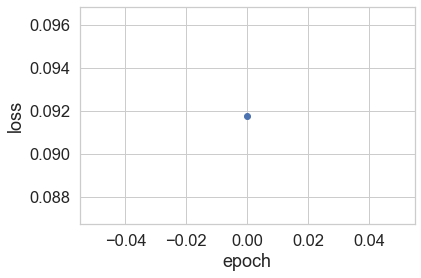

RNN(
  (input_to_hidden): Linear(in_features=54, out_features=50, bias=True)
  (hidden_to_hidden): Linear(in_features=50, out_features=50, bias=True)
  (hidden_to_output): Linear(in_features=50, out_features=54, bias=True)
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
)

In [36]:
# to make this work, you'll need many more epochs and possibly a larger hidden layer.
rnn2 = RNN(len(char_to_ix), 50, len(char_to_ix))
train_rnn(rnn2, batches, epochs=1)

In [37]:
# it just predicts "space" characters after 1 epoch!
rnn2.verbose=True
rnn2.forward_unrolled(chars2vec('thy', char_to_ix))

h_new
 tensor([[ 0.4809,  0.3574,  0.1164, -0.2460,  0.2098, -0.2316,  0.1119, -0.3625,
          0.2217, -0.3929,  0.3368, -0.4963, -0.3168,  0.0843, -0.1177, -0.0918,
          0.0817, -0.2091,  0.1943,  0.0609,  0.1960, -0.0504, -0.0488, -0.3472,
          0.1754, -0.3925,  0.1620, -0.4792,  0.4109, -0.1475, -0.2367,  0.4025,
         -0.2030,  0.3301,  0.1878,  0.1463,  0.4948,  0.0071, -0.2769, -0.0038,
          0.1008,  0.2266,  0.0110,  0.3804,  0.1716,  0.1656,  0.0525, -0.0737,
          0.0822, -0.1795]], grad_fn=<TanhBackward>) 
output
 tensor([[0.0116, 0.0143, 0.0143, 0.0141, 0.0447, 0.0122, 0.0348, 0.0107, 0.0123,
         0.0179, 0.0582, 0.0158, 0.0663, 0.0108, 0.0133, 0.0111, 0.0090, 0.0158,
         0.0141, 0.0160, 0.0152, 0.0132, 0.0522, 0.0433, 0.0120, 0.0126, 0.0132,
         0.0143, 0.0130, 0.0134, 0.0140, 0.0131, 0.0156, 0.0138, 0.0126, 0.0157,
         0.0470, 0.0082, 0.0520, 0.0102, 0.0134, 0.0154, 0.0122, 0.0112, 0.0101,
         0.0109, 0.0160, 0.0103, 0.0114,

(tensor([[0.0116, 0.0143, 0.0143, 0.0141, 0.0447, 0.0122, 0.0348, 0.0107, 0.0123,
          0.0179, 0.0582, 0.0158, 0.0663, 0.0108, 0.0133, 0.0111, 0.0090, 0.0158,
          0.0141, 0.0160, 0.0152, 0.0132, 0.0522, 0.0433, 0.0120, 0.0126, 0.0132,
          0.0143, 0.0130, 0.0134, 0.0140, 0.0131, 0.0156, 0.0138, 0.0126, 0.0157,
          0.0470, 0.0082, 0.0520, 0.0102, 0.0134, 0.0154, 0.0122, 0.0112, 0.0101,
          0.0109, 0.0160, 0.0103, 0.0114, 0.0140, 0.0157, 0.0099, 0.0139, 0.0137],
         [0.0096, 0.0084, 0.0091, 0.0079, 0.0862, 0.0075, 0.0425, 0.0057, 0.0085,
          0.0171, 0.0972, 0.0109, 0.1080, 0.0065, 0.0084, 0.0054, 0.0052, 0.0107,
          0.0071, 0.0142, 0.0098, 0.0054, 0.0846, 0.0739, 0.0044, 0.0067, 0.0071,
          0.0119, 0.0078, 0.0092, 0.0089, 0.0096, 0.0098, 0.0074, 0.0089, 0.0091,
          0.0669, 0.0030, 0.0635, 0.0052, 0.0121, 0.0082, 0.0067, 0.0072, 0.0090,
          0.0053, 0.0102, 0.0065, 0.0064, 0.0065, 0.0088, 0.0081, 0.0065, 0.0095]],
        grad_

More layers and more nodes would improve results:

<u>multi-layer RNN</u>: just stack multiple RNNs together:
```
y1 = rnn1.step(x)
y = rnn2.step(y1)
```

![figs/rnn_stacked.png](figs/rnn_stacked.png)

Backpropagation can in turn be performed on both networks together.
<br>

3-layer RNN, 512 hidden nodes each, trained for a few hours:

![shake](figs/shake.png)

## Bidirectional RNN

How can we incorporate future tokens to help the prediction at time $t$?

![figs/birnn.png](figs/birnn.png)

## Backpropagation through time

- For a single sequence, we can compute back-propagation as in a standard neural net.
- However, because each input sequence has a different length, we have neural nets with different numbers of layers.
- To deal with this, we can collect all sequences of length $t$ and do training on them, then proceed to sequences of length $t+1$:


Repeat:

for $t=1 \ldots T\:\:\:$ ($T$=max length of any sequence):
  - Unfold your neural network in time for $t$ time steps to create a standard feed-forward net.
  - Perform forward and backward propagation as in a normal network.
  - Average all the gradients at each layer, so that the weight update to the matrices is the same in each time step.



#### sources
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/

In [ ]:
from IPython.core.display import HTML
HTML(open('../custom.css').read())